<a href="https://colab.research.google.com/github/nyreemarsh/qm2_diabetesinbrazil/blob/main/correlation_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)

The objective here is to firstly, make a Pandas DataFrame containing a multitude of social factors, such that we can later perform an OLS regression.

In [ ]:
# Going to start by calling the prevalence data of Brazil type 2 diabetes 'ddf'.

# Data is from https://vizhub.healthdata.org/gbd-results/.

ddf = pd.read_csv('Prevalence Data.csv')
ddf = ddf[ddf['age_name']=='All ages']

# Starting by considering percentage

ddf = ddf[ddf['metric_name']=='Percent']

ddf = ddf[ddf['location_name']=='Brazil']
ddf['Type 2 Diabetes Percentage Prevalence'] = ddf['val']

ddf = ddf[['year','Type 2 Diabetes Percentage Prevalence']]
ddf.head()

,year,Type 2 Diabetes Percentage Prevalence
1,1990,0.030053
4,1991,0.030250
7,1992,0.030475
10,1993,0.030720
13,1994,0.031002


In [ ]:
# This is Unemployment Percentage Growth Data from https://www.macrotrends.net/countries/BRA/brazil/unemployment-rate.
unem = pd.read_csv('Unemployment.csv')
unem.head()

unem.columns = unem.iloc[0]
unem = unem.drop(0)
unem['date'] = pd.to_datetime(unem['date'], format='%d/%m/%Y')
unem['year'] = unem['date'].dt.year
unem['Unemployment Rate (%)'] = unem[' Unemployment Rate (%)']
unem = unem[['year','Unemployment Rate (%)']]
unem.head()

,year,Unemployment Rate (%)
1,1991,6.366
2,1992,6.42
3,1993,6.03
4,1994,6.47
5,1995,7.09


In [ ]:
# This is GDP Percentage Growth data from https://www.macrotrends.net/countries/BRA/brazil/gdp-growth-rate#google_vignette.

gdp = pd.read_csv('Brazil GPD.csv')
gdp.columns = gdp.iloc[0]
gdp = gdp.drop(0)
gdp['date'] = pd.to_datetime(gdp['date'], format='%d/%m/%Y')
gdp['year'] = gdp['date'].dt.year
gdp['GDP Growth (%)'] = gdp[' GDP Growth (%)']
gdp = gdp[['year','GDP Growth (%)']]
gdp.head()


,year,GDP Growth (%)
1,1961,8.6
2,1962,6.6
3,1963,0.6
4,1964,3.4
5,1965,2.4


In [ ]:
# Now schooling data. This is from https://data.humdata.org/dataset/world-bank-education-indicators-for-brazil/resource/215622b2-e690-4c61-a85c-3bf746669681?view_id=1e5e16d6-2761-4e54-bf12-bf4bda7798e2.
# Its metric is enrolment in secondary school education.

sch = pd.read_csv('BrazilEducation.csv')
sch = sch[sch['Indicator Code']=='UIS.E.2']
sch.head()
sch['year']=sch['Year']
sch.sort_values(by='year',ascending=True)
sch.head()

,Country ISO3,Year,Indicator Code,Value,year
1,BRA,2018,UIS.E.2,13340212,2018
2,BRA,2017,UIS.E.2,13414172,2017
3,BRA,2016,UIS.E.2,13678448,2016
4,BRA,2015,UIS.E.2,13814655,2015
5,BRA,2014,UIS.E.2,14285779,2014


In [ ]:
# Now we need to turn this into a percentage by using population data from https://www.macrotrends.net/countries/BRA/brazil/population.



pop = pd.read_csv('BrazilPopNewData.csv')
pop.head()
pop['date']=pop['date'] = pd.to_datetime(pop['date'], format='%d/%m/%Y')
pop['year']=pop['date'].dt.year

pop = pop[pop['year']>=1990]
pop = pop[pop['year']<=2018]
pop['Population']=pop[' Population']
pop['year']=pop['year'].astype('int64')
sch['year']=sch['year'].astype('int64')

# Now, we are going to calculate the percentage of Brazil population enrolled by taking the number of students enrolled over the population each year, and then multiplying
# This value by 100. We will then merge these into one dataframe, which will be called "pop".

pop=pd.merge(pop,sch,on='year')

# Here, we are converting our string data into integers, so we can perform calculations on them.

pop['Population'],pop['Value']=pop['Population'].astype(int),pop['Value'].astype(int)
pop['Population Enrolled in Secondary School (%)']=(pop['Value']/pop['Population'])*100
pop = pop[['Population Enrolled in Secondary School (%)','year']]

In [ ]:
# Now, we merge these datasets into one called 'reg_df', which is what we will use for our regression calculations.

reg_df = pd.merge(ddf,unem,on='year')
reg_df = pd.merge(reg_df,gdp,on='year')
pop['year']=pop['year'].astype(int)
reg_df = pd.merge(reg_df,pop,on='year')
reg_df = reg_df.drop('year',axis=1)
reg_df = pd.DataFrame(reg_df)
reg_df.corr(numeric_only=False)

,Type 2 Diabetes Percentage Prevalence,Unemployment Rate (%),GDP Growth (%),Population Enrolled in Secondary School (%)
Type 2 Diabetes Percentage Prevalence,1.000000,-0.119261,-0.366870,-0.951429
Unemployment Rate (%),-0.119261,1.000000,-0.234777,0.208164
GDP Growth (%),-0.366870,-0.234777,1.000000,0.222766
Population Enrolled in Secondary School (%),-0.951429,0.208164,0.222766,1.000000


In [ ]:
# Here, we are going to make a separate dataset, abbreviating the tick names, to make the regression matrix easier to interpret.

abbr = reg_df

abbr['GPD %']=abbr['GDP Growth (%)']
abbr = abbr.drop('GDP Growth (%)',axis=1)
abbr['Diabetes (%)']=abbr['Type 2 Diabetes Percentage Prevalence']
abbr = abbr.drop('Type 2 Diabetes Percentage Prevalence',axis=1)
abbr['Unem (%)']=abbr['Unemployment Rate (%)']
abbr = abbr.drop('Unemployment Rate (%)',axis=1)
abbr['Enrollment (%)']=abbr['Population Enrolled in Secondary School (%)']
abbr = abbr.drop('Population Enrolled in Secondary School (%)',axis=1)

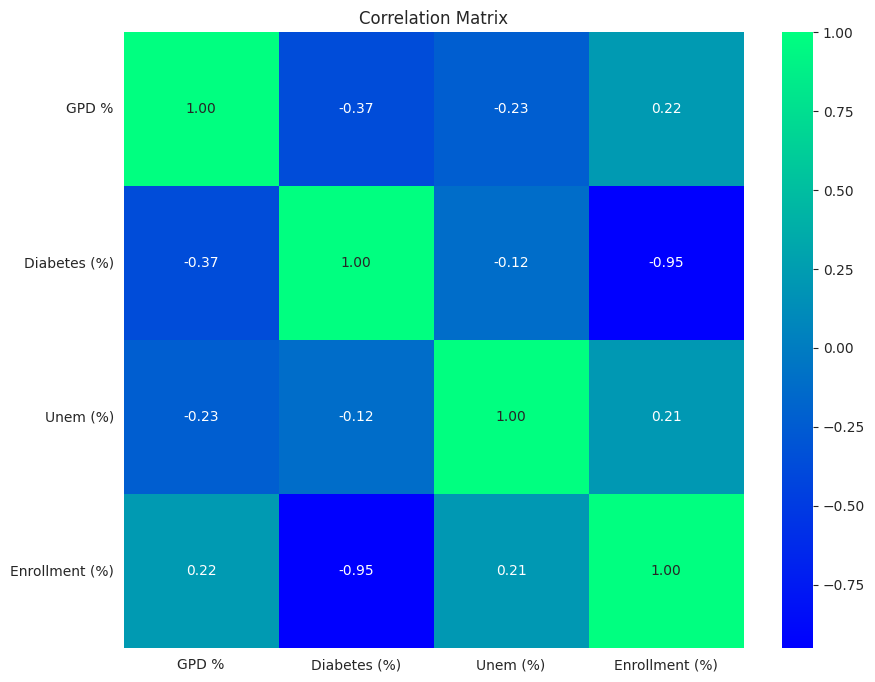

In [ ]:
# Now, we can plot our regression matrix.

sns.set_style('darkgrid')
plot = sns.heatmap(abbr.corr(numeric_only=False), annot=True, fmt=".2f", cmap='winter')
plot.set_yticklabels(plot.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=10)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Next, our OLS regression.

reg_df = pd.DataFrame(reg_df)

# To avoid errors in the OLS function, we need to use the 'pd.to_numeric' function, as our data contained some non-numeric values.

reg_df['Type 2 Diabetes Percentage Prevalence'] = pd.to_numeric(reg_df['Type 2 Diabetes Percentage Prevalence'])
reg_df['Unemployment Rate (%)'] = pd.to_numeric(reg_df['Unemployment Rate (%)'])
reg_df['GDP Growth (%)'] = pd.to_numeric(reg_df['GDP Growth (%)'])
reg_df['Population Enrolled in Secondary School (%)'] = pd.to_numeric(reg_df['Population Enrolled in Secondary School (%)'])
x = sm.add_constant(reg_df[['Unemployment Rate (%)', 'GDP Growth (%)', 'Population Enrolled in Secondary School (%)']])
y = reg_df['Type 2 Diabetes Percentage Prevalence']
model = sm.OLS(y, x).fit()
print(model.summary())

                                      OLS Regression Results                                     
Dep. Variable:     Type 2 Diabetes Percentage Prevalence   R-squared:                       0.932
Model:                                               OLS   Adj. R-squared:                  0.918
Method:                                    Least Squares   F-statistic:                     68.22
Date:                                   Fri, 05 Jan 2024   Prob (F-statistic):           5.68e-09
Time:                                           16:42:08   Log-Likelihood:                 90.620
No. Observations:                                     19   AIC:                            -173.2
Df Residuals:                                         15   BIC:                            -169.5
Df Model:                                              3                                         
Covariance Type:                               nonrobust                                         
                    

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
# Even though out correlation matrix shows little correlation between our independent variables, we should still adress multicollinearity by removing and factors which have an
# exceptionally high VIF.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):

    while True:
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i)
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        vif_df = vif_df.drop('const')

        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)

        print('Max VIF:', vif_df.VIF.max())

        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break

    return df

ind_vars=['Unemployment Rate (%)','GDP Growth (%)','Population Enrolled in Secondary School (%)']

vif = drop_column_using_vif_(reg_df[ind_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 1.1524049375256022
The columns remaining after VIF selection are:
Index(['Unemployment Rate (%)', 'GDP Growth (%)',
       'Population Enrolled in Secondary School (%)'],
      dtype='object')


Thus, we have no need to remove any factors, and the assumption of negligible collinearity has been satisfied.